# Goal

The idea of this notebook is to pre-process the image in order to make is easier to segment. Here are few things that we are going to do:

- Try to improve the contrast of the image by thresholding/playing with the intensity distribution (automatically)
- Try to "remove" background by segmenting algea that are in the middle of the image
- Removing pixels that are static ?

## Import the necessary packages

In [363]:
import skimage
import napari
from tifffile import imread,imwrite
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.measure as sm
import seaborn as sns
import os

### Load a "raw image"

In [47]:
path = Path('../data/tricho_8.tif')
im = imread(path)
print(np.shape(im))

(346, 576, 576)


# Thresholding

In [93]:
# Display the intensity profile of the image by making a gif of the histogram of all "planes"

data = im[0,...].flatten()
n, _ = np.histogram(data)

def prepare_animation(bar_container):
     
    def animate(frame_number):
        data = im[frame_number,...].flatten()
        n, _ = np.histogram(data)
         
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
         
        return bar_container.patches
     
    return animate


frame_number = np.shape(im)[0] # number of frames you want to plot np.shape(im)[0] if you want all of them

fig, ax = plt.subplots(figsize=(5, 5))

_, _, bar_container = ax.hist(data, lw=1,ec="red", fc="black", alpha=0.5)
plt.close()

ax.set_ylabel("Intensity")
ax.set_xlabel("Count")

fig.tight_layout()
ani = animation.FuncAnimation(fig, prepare_animation(bar_container), frame_number,repeat=True, blit=True)
HTML(ani.to_jshtml())


In [410]:
f = r"../data/results/figures/contrast_enhancement/animation_intensity_time.gif" 
writergif = animation.PillowWriter(fps=5) 
ani.save(f, writer=writergif)

Determine the percentage of area occupied by the trichoplast and use it as a cut-off value

# Segmenting the algae 

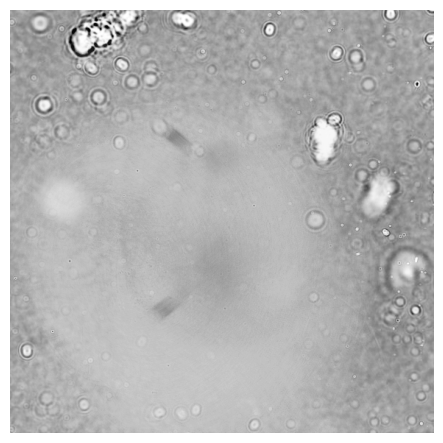

In [131]:
#projecting the image in order to average all plane and get the position of the static elements

im_p = np.mean(im,axis=0)
plt.axis('off')
plt.imshow(im_p,origin='lower')

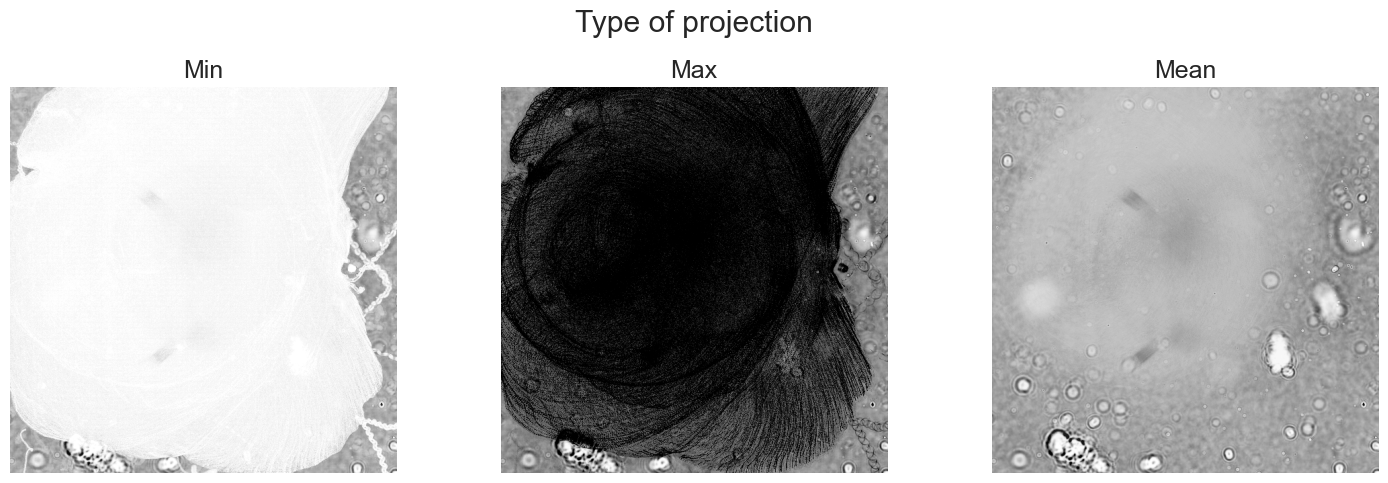

In [114]:
sns.set_context("talk")
# Plot the difference between mean,min and max projection

fig,ax = plt.subplots(1,3,figsize=(15,5))
l = ['Min','Max','Mean']

op = [np.min(im,axis=0),np.max(im,axis=0),np.mean(im,axis=0)]
for i,ax,l in zip(op,ax,l):
    ax.imshow(i)
    ax.set_title(l)
    ax.axis('off')
    
fig.suptitle('Type of projection')
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/type_of_projection.png',dpi=300)
plt.show()

We can stick to the mean projection to perform the segmentation

(array([  1671.,   1894.,   4805., 125195., 165667.,  28874.,   2583.,
           551.,    273.,    263.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

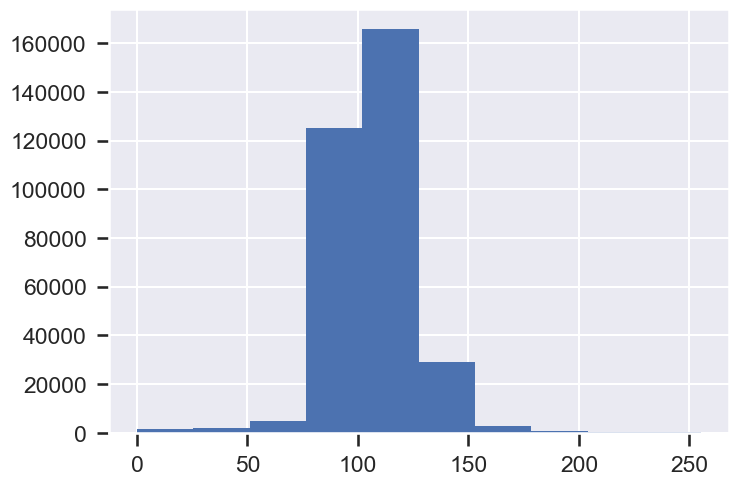

In [403]:
# Plot the intensity histogram to see where are the algae 
plt.hist(im_p.flatten())

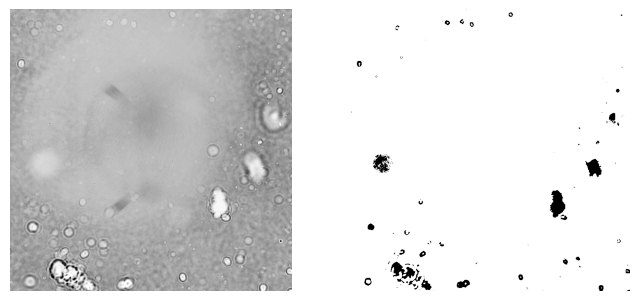

In [404]:
# inverse the color such that algea are high pixel intensity

fix,ax = plt.subplots(1,2)
i = im_p.copy()

i[i > 70] = 255.

i[i<255] = 1.

i[i != 1.] = 0.

ax[0].imshow(im_p)
ax[1].imshow(i)

for ax in ax:
    ax.axis('off')

In [382]:
# segment 

from skimage.segmentation import chan_vese,checkerboard_level_set

image = i.copy()

init_ls = checkerboard_level_set(image.shape, 6)

cv = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5,
               extended_output=True,init_level_set=init_ls)


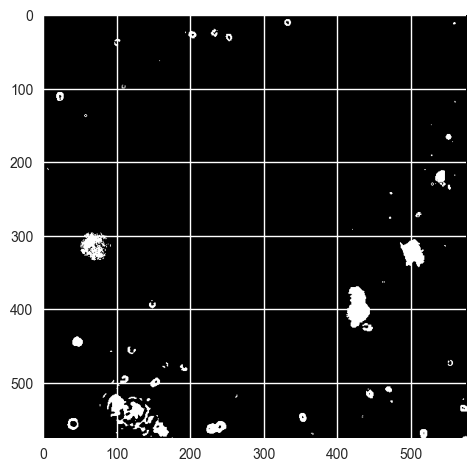

In [399]:
plt.imshow(cv[0])
plt.show()

In [400]:
lab = label(cv[0])
props = regionprops_table(lab, properties=('centroid','area'))

df = pd.DataFrame(props)
df.head()

centroid-0  centroid-1    area
0  284.983767  287.859072  325080
1   11.071429  331.714286      14
2   27.714286  203.000000       7
3   31.428571  252.214286      14
4  112.500000   22.785714      14

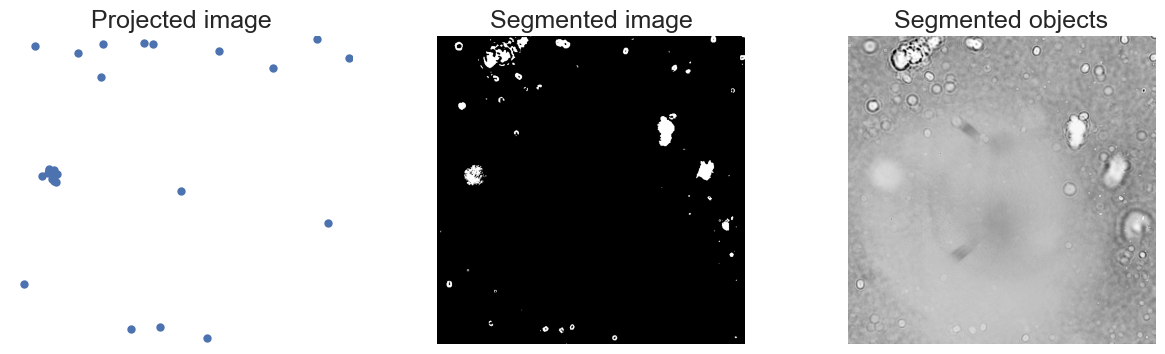

In [402]:
sns.set_context("talk")
fix,ax = plt.subplots(1,3,figsize=(15,4),sharex=True,sharey=True)

ax[0].scatter(df['centroid-1'],df['centroid-0'],marker='.')
ax[1].imshow(cv[0],origin='lower')
ax[2].imshow(im_p,origin='lower')

fig.tight_layout()
title = ['Projected image','Segmented image','Segmented objects']
for ax,t in zip(ax,title):
    ax.axis('off')
    ax.set_title(t)

plt.savefig('../data/results/figures/contrast_enhancement/algea_detection.png',dpi=300)
plt.show()